# **Class 7 - ML - Fast Ai**:  Building a Random Forest from Scratch

In [0]:
!pip install fastai==0.7.0 

In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [0]:
#create gdrive folder inside content
from google.colab import drive
drive.mount('/content/gdrive')

#we create a kaggle folder 
!mkdir /root/.kaggle
!mkdir ~/.kaggle

#the mounted gdrive should containg the Kaggle json keys, otherwise we upload kaggle.json to colab inside content
!cp /content/gdrive/My\ Drive/kaggle.json ~/.kaggle/kaggle.json

# go to kaggle to get permission to download the data set, then copy the link to upload
!kaggle competitions download -c bluebook-for-bulldozers

In [0]:
!unzip Train.zip

Archive:  Train.zip
  inflating: Train.csv               


In [0]:
df_raw = pd.read_csv(f'Train.csv', low_memory=False, 
                     parse_dates=["saledate"])
df_raw.head

<bound method NDFrame.head of         SalesID  SalePrice  ...  Differential_Type  Steering_Controls
0       1139246      66000  ...           Standard       Conventional
1       1139248      57000  ...           Standard       Conventional
2       1139249      10000  ...                NaN                NaN
3       1139251      38500  ...                NaN                NaN
4       1139253      11000  ...                NaN                NaN
5       1139255      26500  ...                NaN                NaN
6       1139256      21000  ...                NaN                NaN
7       1139261      27000  ...                NaN                NaN
8       1139272      21500  ...                NaN                NaN
9       1139275      65000  ...           Standard       Conventional
10      1139278      24000  ...                NaN                NaN
11      1139282      22500  ...                NaN                NaN
12      1139283      36000  ...                NaN          

In [0]:
#Root mean squared log error
#We use the log to get the % of error as opposed to absolute error which doesn't make much sense

df_raw.SalePrice = np.log(df_raw.SalePrice)

In [0]:
#Transforming the sales date into "year", month, and day columns 
#We could have trends in time, such as higher price during a particular day
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [0]:
#To use a Random Forest model, we need to convert everything into numeric values
train_cats(df_raw)

#We must take into account the hierarchy in some columns containing strings
#It's important to keep an order for the model
df_raw.UsageBand.cat.categories
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)
df_raw.UsageBand = df_raw.UsageBand.cat.codes


In [0]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [0]:
#saving the file into directory 
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

#In the future we can simply read it from this fast format.
df_raw = pd.read_feather('tmp/bulldozers-raw')

In [0]:
df_raw = pd.read_feather('tmp/bulldozers-raw')

In [0]:
#Now we separate the columns into Dependent variable and independent variables
df, y, nas = proc_df(df_raw, 'SalePrice')

In [0]:
#We check that all data is numeric and there is no missing value
display_all(df.isnull().sum().sort_index()/len(df))
display_all(df.describe(include='all').T)

In [0]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

In [0]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [0]:
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [0]:
x_sub = X_train[['YearMade', 'MachineHoursCurrentMeter']]

# **Starting Random Forest Implementation**

In [0]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz] 
        return DecisionTree(self.x.iloc[rnd_idxs], self.y[rnd_idxs], min_leaf=self.min_leaf)  
      #x is a PD dataframe, to go through it, we use iloc. y is a numpy, we can go through it simply by passing index
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

In [0]:
z = np.random.permutation(5)
print(z)
print(z[3:])
u = np.array([3, 33, 333, 33333, 44, 55, 66, 77])
print(u[z])


[0 4 1 3 2]
[3 2]
[    3    44    33 33333   333]


In [0]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf

In [0]:
m = TreeEnsemble(X_train, y_train, n_trees=10, sample_sz=1000, min_leaf=3)

In [0]:
m.trees[0]

In [0]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    # This just does one decision; we'll make it recursive later
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
            
    # We'll write this later!
    def find_better_split(self, var_idx): pass
    
    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

In [0]:
b = np.array([[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4]])
print(b.shape)
print(b.shape[0])

(3, 4)
3


In [0]:
m.trees[0].idxs

In [0]:
idxs=np.arange(10)
print(idxs)
#print(type (y_train))
#print(type(y_train[idxs]))

[0 1 2 3 4 5 6 7 8 9]


# **Single branch**

Find best split given variable

In [0]:
ens = TreeEnsemble(x_sub, y_train, 1, 1000)
tree = ens.trees[0]
x_samp,y_samp = tree.x, tree.y
x_samp.columns

Index(['YearMade', 'MachineHoursCurrentMeter'], dtype='object')

In [0]:
tree

n: 1000; val:10.079014121552744

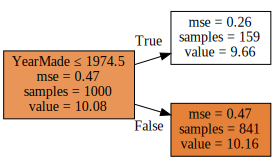

In [0]:
m = RandomForestRegressor(n_estimators=1, max_depth=1, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2)

In [0]:
def find_better_split(self, var_idx):
    x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]

    for i in range(self.n):
        lhs = x<=x[i]
        rhs = x>x[i]
        if rhs.sum()<self.min_leaf or lhs.sum()<self.min_leaf: continue
        lhs_std = y[lhs].std()
        rhs_std = y[rhs].std()
        curr_score = lhs_std*lhs.sum() + rhs_std*rhs.sum()
        if curr_score<self.score: 
            self.var_idx,self.score,self.split = var_idx,curr_score,x[i]

In [0]:
%timeit find_better_split(tree,1)
tree

10 loops, best of 3: 69.8 ms per loop


n: 1000; val:10.079014121552744; score:681.0184057251435; split:3744.0; var:MachineHoursCurrentMeter

In [0]:
find_better_split(tree,0); tree

n: 1000; val:10.079014121552744; score:658.5510186055949; split:1974.0; var:YearMade

# **Speeding things up**

In [0]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]

In [0]:
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

def find_better_split(self, var_idx):
    x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
    
    sort_idx = np.argsort(x)
    sort_y,sort_x = y[sort_idx], x[sort_idx]
    rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
    lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

    for i in range(0,self.n-self.min_leaf):
        xi,yi = sort_x[i],sort_y[i]
        lhs_cnt += 1; rhs_cnt -= 1
        lhs_sum += yi; rhs_sum -= yi
        lhs_sum2 += yi**2; rhs_sum2 -= yi**2
        if i<self.min_leaf-1 or xi==sort_x[i+1]:
            continue
            
        lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
        rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
        curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
        if curr_score<self.score: 
            self.var_idx,self.score,self.split = var_idx,curr_score,xi

In [0]:
%timeit find_better_split(tree,1)
tree

100 loops, best of 3: 2.16 ms per loop


n: 1000; val:10.079014121552744; score:681.0184057251353; split:3744.0; var:MachineHoursCurrentMeter

In [0]:
%timeit find_better_split(tree,0)
tree

100 loops, best of 3: 2.14 ms per loop


n: 1000; val:10.079014121552744; score:658.5510186055565; split:1974.0; var:YearMade

In [0]:
DecisionTree.find_better_split = find_better_split

In [0]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]; tree

n: 1000; val:10.079014121552744; score:658.5510186055565; split:1974.0; var:YearMade

# **Full single tree**

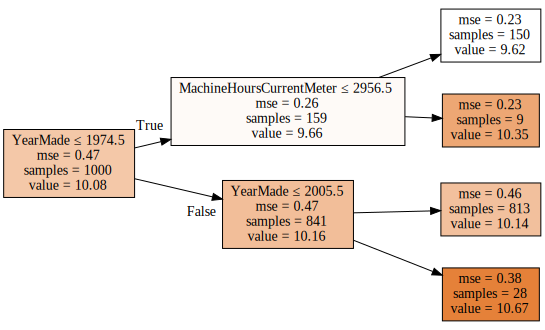

In [0]:
m = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2)

In [0]:
def find_varsplit(self):
    for i in range(self.c): self.find_better_split(i)
    if self.is_leaf: return
    x = self.split_col
    lhs = np.nonzero(x<=self.split)[0]
    rhs = np.nonzero(x>self.split)[0]
    self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
    self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

In [0]:
DecisionTree.find_varsplit = find_varsplit

In [0]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]; tree

n: 1000; val:10.079014121552744; score:658.5510186055565; split:1974.0; var:YearMade

In [0]:
tree.lhs

n: 159; val:9.660892662981706; score:76.82696888346362; split:2800.0; var:MachineHoursCurrentMeter

In [0]:
tree.rhs

n: 841; val:10.158064432982941; score:571.4803525045031; split:2005.0; var:YearMade

In [0]:
tree.lhs.lhs

n: 150; val:9.619280538108496; score:71.15906938383463; split:1000.0; var:YearMade

In [0]:
tree.lhs.lhs

n: 150; val:9.619280538108496; score:71.15906938383463; split:1000.0; var:YearMade

# **Predictions**

In [0]:
cols = ['MachineID', 'YearMade', 'MachineHoursCurrentMeter', 'ProductSize', 'Enclosure',
        'Coupler_System', 'saleYear']

In [0]:
%time tree = TreeEnsemble(X_train[cols], y_train, 1, 1000).trees[0]
x_samp,y_samp = tree.x, tree.y

CPU times: user 457 ms, sys: 13 ms, total: 470 ms
Wall time: 469 ms


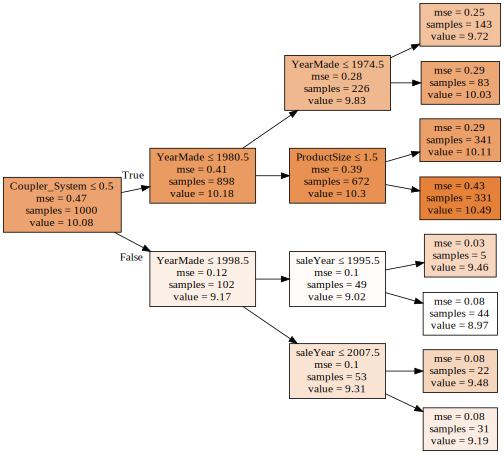

In [0]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2, ratio=0.9, size=7)

In [0]:
def predict(self, x): return np.array([self.predict_row(xi) for xi in x])
DecisionTree.predict = predict

In [0]:
def predict_row(self, xi):
    if self.is_leaf: return self.val
    t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
    return t.predict_row(xi)

DecisionTree.predict_row = predict_row

In [0]:
%time preds = tree.predict(X_valid[cols].values)

CPU times: user 88.3 ms, sys: 3.98 ms, total: 92.3 ms
Wall time: 92.1 ms


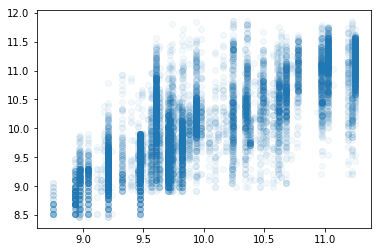

In [0]:
plt.scatter(preds, y_valid, alpha=0.05)

In [0]:
metrics.r2_score(preds, y_valid)

0.4840854669925271

CPU times: user 5.31 ms, sys: 11 µs, total: 5.32 ms
Wall time: 4.83 ms


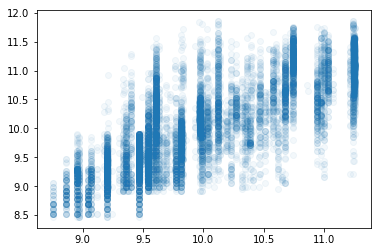

In [0]:
m = RandomForestRegressor(n_estimators=1, min_samples_leaf=5, bootstrap=False)
%time m.fit(x_samp, y_samp)
preds = m.predict(X_valid[cols].values)
plt.scatter(preds, y_valid, alpha=0.05)

In [0]:
metrics.r2_score(preds, y_valid)

0.47541053100694797